In [1]:
import time
import pyjet
import numpy as np
import h5py
import uproot
import pandas as pd
from tqdm import tqdm

from BranchClass import *


import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
from matplotlib import cm

In [2]:
def M(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    return np.sqrt((e1+e2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2)

def MJJ(j1,j2):
    pt1, eta1, phi1, m1 = j1.pt,j1.eta,j1.phi,j1.mass
    pt2, eta2, phi2, m2 = j2.pt,j2.eta,j2.phi,j2.mass
    
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    return np.sqrt((e1+e2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2)

def digit(loc,pid):
    #     //  PID digits (base 10) are: n nr nl nq1 nq2 nq3 nj
    #     //   nj = 1, nq3=2 , nq2=3, nq1, nl, nr, n, n8, n9, n10 
    #     //  the location enum provides a convenient index into the PID
    numerator = 10**(loc-1)
    
    return int((abs(pid)/numerator)%10)

def hasBottom(pid):
    # get B hadron
    # PID for B hadron are 5XX, 5XXX
    # https://gitlab.com/hepcedar/rivet/-/blob/release-3-1-x/analyses/pluginCMS/CMS_2015_I1370682.cc#L390
    # https://rivet.hepforge.org/code/2.1.0/a00827.html#ad4c917595339ea52152c2950ce1225e7
    # https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf
    if( digit(2,pid) == 5 or digit(3,pid) == 5 or digit(4,pid) == 5 ):
        return True
    else:
        return False


def Event_List(GenParticle, Jet, path="./data_gzip.h5"):
    print("Make Event List")
    print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
    time.sleep(1)
    ticks_1 = time.time()
    
    k = 0
    bbbb_list = []
    event_list = []
    bb1_P4, bb2_P4 = [], []
    Mbbbb = []
    bhadron_list = []
    
    hf = h5py.File(path, 'w')
    for N in tqdm(range(GenParticle.length)):

        event_list_tmp = []
        
        event_list_tmp.append([GenParticle.PT_At(N),  GenParticle.Eta_At(N), \
                               GenParticle.Phi_At(N), GenParticle.Mass_At(N), \
                               GenParticle.PID_At(N), GenParticle.Status_At(N),\
                               GenParticle.Charge_At(N),\
                               np.full(len(GenParticle.PT_At(N)),0), #for B hadron tag
                               GenParticle.M1_At(N), GenParticle.M2_At(N),\
                               GenParticle.D1_At(N), GenParticle.D2_At(N),\
                               

                              ])
        
        event_list_tmp = np.array(event_list_tmp)
        
    
        """
        Find All B Hadrons
        """
        unstable_hadron = event_list_tmp[0][:,np.abs(event_list_tmp[0][5,:])==2]
        bhadron_index = np.where(np.vectorize(hasBottom)(unstable_hadron[4,:])==True)[0] 
        bhadron = unstable_hadron[:,bhadron_index]
        bhadron_list_tmp = []
        
        """
        Find B Hadrons before decay
        """
        for i in range(len(bhadron[0])):   
            if hasBottom(GenParticle.PID_At(N)[int(bhadron[10][i])]) == False and hasBottom(GenParticle.PID_At(N)[int(bhadron[11][i])]) == False:
                bhadron_list_tmp.append(bhadron[:,i])
        
        """
        Ghost Association Method: create ghost-associated B Hadrons
        """
        Ghostparam = 1E-20
        for i, element in enumerate(bhadron_list_tmp):
            bhadron_list_tmp[i][0] = element[0]*Ghostparam  # PT*Ghostparam
            bhadron_list_tmp[i][3] = element[3]*Ghostparam  # Mass*Ghostparam
            bhadron_list_tmp[i][7] = 1                      #B Hadron tag 
        
        """
        Pick stable final state particel (status = 1) and filter ou neutrinos (|PID| = 12, 14, 16)
        """
        event_list_tmp = event_list_tmp[0][:,event_list_tmp[0][5,:]==1] 
        event_list_tmp = event_list_tmp[:,np.abs(event_list_tmp[4,:])!=12]
        event_list_tmp = event_list_tmp[:,np.abs(event_list_tmp[4,:])!=14]
        event_list_tmp = event_list_tmp[:,np.abs(event_list_tmp[4,:])!=16]
        
        """
        Ghost Association Method: add ghost-associated B Hadrons
        """
        event_list_tmp = np.concatenate((np.array(event_list_tmp).transpose(),bhadron_list_tmp)).transpose()
        
        event_list.append(event_list_tmp)
        
        hf.create_dataset("GenParticle/dataset_" + str(N), data=event_list_tmp, compression="gzip", compression_opts=5)
    
        k += 1
        
        if k > 10000:
            break
        
        
        
    k = 0
    jet_list = []
    
    for N in range(Jet.length):
        
        jet_list_tmp = []
        jet_list_tmp_tmp = []


        jet_list_tmp.append([Jet.PT_At(N),  Jet.Eta_At(N), \
                               Jet.Phi_At(N), Jet.Mass_At(N), \
                               Jet.Charge_At(N), Jet.BTag_At(N)
                              ])


        
        jet_list_tmp = np.array(jet_list_tmp)

        jet_list_tmp = jet_list_tmp[0]#[:,jet_list_tmp[0][5,:]==1]
#         jet_list_tmp = jet_list_tmp[:,np.abs(jet_list_tmp[4,:])!=12]
        
        jet_list.append(jet_list_tmp)
        
        hf.create_dataset("Jet/dataset_" + str(N), data=jet_list_tmp, compression="gzip", compression_opts=5)
        
        k += 1
        
        if k > 10000:
            break
        
        
    hf.close()

    ticks_2 = time.time()
    totaltime =  ticks_2 - ticks_1
    print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))
    
#     return event_list





In [11]:
# path = "."
path = "/home/u5/Universality_DiHiggs/Pythia_default"

process_path_pythia_default_H = path + "/ppHhh_pythia_def_1.root"

try:
    pythia_default_H = uproot.open(process_path_pythia_default_H)["Delphes;1"]
    
    print("All Files are loaded!")
    
except:
    print("Please Check Input Files")



All Files are loaded!


In [ ]:
pythia_default_H.show()

In [13]:
GenParticle_pythia_default_H = BranchGenParticles(pythia_default_H)
# Jet_pythia_default_H = BranchJet(pythia_default_H)
Jet_pythia_default_H = BranchParticleFlowJet10(pythia_default_H)


In [14]:
# Jet_List(Jet_pythia_default_H)

In [15]:
events = Event_List(GenParticle_pythia_default_H,Jet_pythia_default_H)

Make Event List
Tue Jun 15 15:59:07 2021


 10%|█         | 10000/100000 [00:22<03:21, 446.04it/s]


Time Cost : 0.4277 min


In [16]:
hf_read = h5py.File("./data_gzip.h5", 'r')

In [ ]:
for name in hf_read:
    print(name)
    for name_name in hf_read[name]:
        print(name_name)

In [17]:
process_list_clustered = []
Higgs_candidate = []


print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
time.sleep(1)
ticks_1 = time.time()
counter = 0

for i in tqdm(range(len(hf_read["GenParticle"]))):

    """
    Jet clustering 
    Fat jet: R = 1
    Anti-kt
    """
    to_cluster = np.core.records.fromarrays(hf_read.get('GenParticle/dataset_'+ str(i))[:8], 
                                            names="pt, eta, phi, mass, PID, Status, Charge, B_tag",
                                            formats = "f8, f8, f8, f8, f8, f8, f8, f8"
                                           )
    pt_min = 25
    sequence_cluster = pyjet.cluster(to_cluster, R = 1, p = -1) # p = -1: anti-kt , 0: Cambridge-Aachen(C/A), 1: kt
    jets_cluster = sequence_cluster.inclusive_jets(pt_min)
    process_list_clustered.append(jets_cluster)

    """
    Find two-B-hadron-tag jet (Higgs candidate)
    """
    Higgs_candidate_tmp = []
    for jet in jets_cluster:
        B_tag = 0
        for constituent in jet:
            if constituent.B_tag == 1:
                B_tag += 1
        if B_tag >= 2:
            Higgs_candidate_tmp.append(jet)

    if len(Higgs_candidate_tmp) >= 2:
        Higgs_candidate.append(Higgs_candidate_tmp)


    counter += 1 
    if counter == 10000:
        break 

ticks_2 = time.time()
totaltime =  ticks_2 - ticks_1
print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))
print("\n")

# print(len(process_list_clustered))

Tue Jun 15 15:59:34 2021


100%|█████████▉| 9999/10001 [01:28<00:00, 113.60it/s]

Time Cost : 1.4673 min




In [18]:
dataframe = pd.DataFrame()
    
features = ["MJJ_truth", "delta_eta_truth",
            "MJJ_det", "delta_eta_det"
           ]


k = 0
for N in tqdm(range(len(process_list_clustered))):
#     if len(event_list_clustered[N]) >= 2: # at least two jets in this event.
    jet_list_tmp = hf_read["Jet/dataset_"+str(N)]
    b_tag = jet_list_tmp[:,jet_list_tmp[5,:]==1]
    if len(jet_list_tmp[0]) >= 2:# and len(b_tag[0]) >=2 : # at least two jets in this event.
        
#         print("N", N)
        var = []
        
#         var.append(GEN)
#         var.append(SHO)
#         var.append(PRO)
        
        jet_1_untrimmed = process_list_clustered[N][0] #leading jet's information
        jet_2_untrimmed = process_list_clustered[N][1] #subleading jet's information
        
        var.append(MJJ(jet_1_untrimmed,jet_2_untrimmed))
        var.append(abs(jet_1_untrimmed.eta-jet_2_untrimmed.eta))
        
        
        "Jet"
        """
        pT, eta, phi, mass, charge, b_tag"
        0 ,  1,  2,   3,    4,      5
        """
#         jet_list_tmp = hf_read["Jet/dataset_"+str(N)]
    
#         print(hf_read["Jet/dataset_"+str(N)])
#         jet_list_tmp = b_tag
    
        pt1 = jet_list_tmp[0][0]
        pt2 = jet_list_tmp[0][1]
        eta1 = jet_list_tmp[1][0]
        eta2 = jet_list_tmp[1][1]
        phi1 = jet_list_tmp[2][0]
        phi2 = jet_list_tmp[2][1]
        m1 = jet_list_tmp[3][0]
        m2 = jet_list_tmp[3][1]
        
        #   b_tag = jet_list_tmp[:,jet_list_tmp[5,:]==1]
        
        var.append(M(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2))
        var.append(abs(eta1-eta2))
        
        
        
        
        
        dataframe_tmp = pd.DataFrame([var],columns=features)
        dataframe = dataframe.append(dataframe_tmp, ignore_index = True)
        
dataframe.to_csv( "./test.csv", index = 0)


100%|██████████| 10000/10000 [00:23<00:00, 417.34it/s]


In [49]:
jet_list_tmp = hf_read["Jet/dataset_2"]
jet_list_tmp[:]

array([[321.78671265, 268.15380859],
       [ -0.34810144,  -0.8727563 ],
       [  0.79361022,  -2.3663311 ],
       [ 38.11644745,  37.52404404],
       [  1.        ,  -2.        ],
       [  0.        ,   0.        ]])

In [41]:
jet_list_tmp = jet_list_tmp[:,jet_list_tmp[5,:]==1]
jet_list_tmp

array([], shape=(6, 0), dtype=float64)

In [19]:
data = pd.read_csv("./test.csv")

In [20]:
data.columns

Index(['MJJ_truth', 'delta_eta_truth', 'MJJ_det', 'delta_eta_det'], dtype='object')

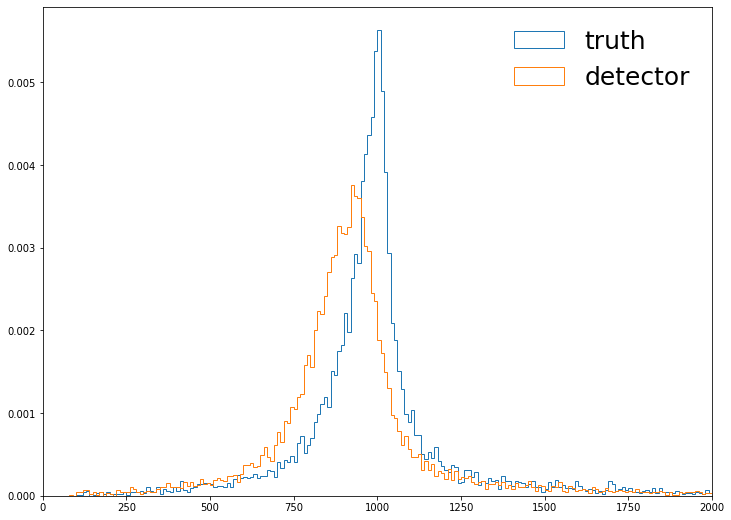

In [21]:
fig, ax = plt.subplots(1,1, figsize=(12,9))

length = np.linspace(0,2000,201)

plt.hist(data["MJJ_truth"], density=1, bins=length,histtype="step", label="truth")
plt.hist(data["MJJ_det"], density=1, bins=length,histtype="step", label="detector")

plt.ylim((0.))
plt.xlim((0.,2000))
plt.legend(loc="best",ncol=1,fontsize=25, edgecolor = "w",fancybox=False, framealpha=0)

plt.show()  

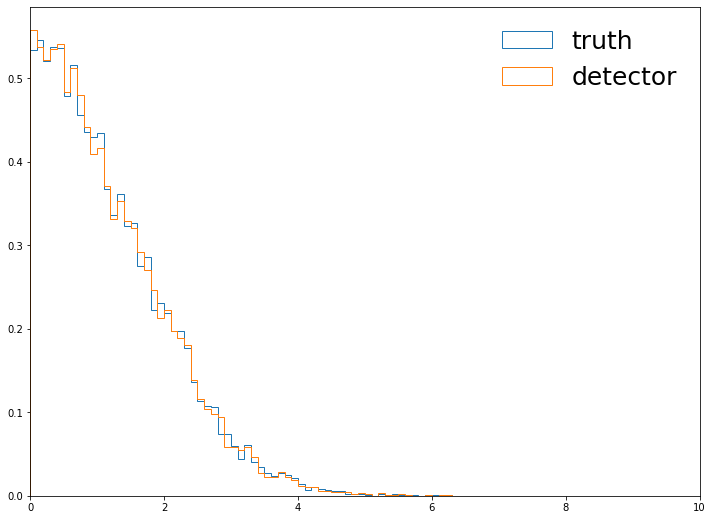

In [22]:
fig, ax = plt.subplots(1,1, figsize=(12,9))

length = np.linspace(0,20,201)

plt.hist(data["delta_eta_truth"], density=1, bins=length,histtype="step", label="truth")
plt.hist(data["delta_eta_det"], density=1, bins=length,histtype="step", label="detector")

plt.ylim((0.))
plt.xlim((0.,10))
plt.legend(loc="best",ncol=1,fontsize=25, edgecolor = "w",fancybox=False, framealpha=0)

plt.show()  